# 14. 데이터 불균형

데이터 불균형이란 데이터 세트 내의 클래스의 분포가 불균형한 것을 의미한다. 데이터 불균형은 특정 클래스에 과적합 되는 현상을 유발할 수 있기 때문에 반드시 해결해야 하는 문제다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd/content/gdrive/My Drive/deeplearningbro/pytorch

## 14.1 Weighted Random Sampling


In [ ]:
# 각 클래스의 비율을 정하여 뽑힐 확률에 대한 가중치를 산정한다.
# 배치마다 각 클래스의 비율을 일정하게 유지 시켜줄 수 있도록한다.
# 실제 데이터가 강아지 6개, 고양이 4개, 새 4개 일 경우
# 각 배치에 강아지 2개, 고양이 2개, 새 2개 등의 형식으로 일정한 비율이 올 수 있도록 조정한다.
import torch
from torch.utils.data import DataLoader
import torchvision
import numpy as np

def make_weights_for_balanced_classes(img, nclasses):

    labels = []
    for i in range(len(img)):
        labels.append(img[i][1])

    label_array = np.array(labels)
    total = len(labels)

    count_list = []
    for cls in range(nclasses):
        count = len(np.where(label_array == cls)[0])
        count_list.append(total/count)

    weights = []
    for label in label_array:
        weights.append(count_list[label])

    return weights


In [ ]:
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf) # 데이터 세트 불러오기

weights = make_weights_for_balanced_classes(trainset.imgs, len(trainset.classes)) # 가중치 계산
weights = torch.DoubleTensor(weights) # 텐서 변환
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 샘플링 방법 정의

trainloader = DataLoader(trainset, batch_size=16, sampler=sampler) # 데이터 로더 정의

# 가중 샘플링에 대해한 의문점

ex)
-개 이미지 800개
-고양이 이미지 200개
데이터셋을 단순히 배치사이즈를 10으로 하였을때, 평균적으로 개 이미지 8개, 고양이 이미지2개가 들어가게 됩니다.
 
이를 위의 sampler 방식을 사용하게 되면 배치 내에 평균 5개씩 이미지가 들어가게 되었는데요
 
의문점은
1) 실제 개 이미지 중 300개는 아예 쓰지 못하게 되고, 고양이 이미지는 중복으로 더 들어가게 되는 상황이 되더라구요. 이러면 사용하지 못하는 이미지가 생기게 되는데, 사용하지 못하는 이미지를 활용할 수 있는 방법은 없는지요?
 
2) 위의 문제를 해결하기 위해 data_augmentation을 보조수단으로 써서 불균형 차이를 줄이는 것도 방법이 되는것인가요?

가중 샘플링 방식은 확률적 샘플링이기 때문에 전체 데이터 사용이 보장이 안 됩니다. 그럼에도 균형된 배치를 사용할 수 있기 때문에 랜덤 샘플링 보다는 더 좋은 성능이 이끌어 냅니다. 아주 오래 전에 저도 실제 연구에서 고민했던 질문이라 반갑습니다. 제가 시도 했던 방법은 크게 다음과 같습니다.

1. 가중 샘플링을 사용하되 데이터를 더 많이 활용할 수 있도록 에폭 수를 늘려 샘플링을 보다 많이 하게 한다.

2. 클래스마다 데이터 증식의 개수를 다르게 하여 불균형을 줄여준 뒤 무작위 샘플링을 진행한다. (oversampling)

3. 가장 수가 작은 클래스 기준으로 다른 클래스를 부분집합으로 나누어 매 에폭마다 돌아가면서 사용한다. (변형 된 undersampling)

4. 클래스가 가장 큰 데이터에 대해서 데이터 분석을 하여 일부를 추출하여 학습에 사용한다. 즉, 오히려 큰 클래스에 대해서 데이터가 덜 사용 됨을 인정하고 중요하다고 생각하는 데이터만 주입한다. (데이터 분석 후 가중 샘플링)

저의 경우 4번이 가장 큰 효과가 있었습니다.

##14.2 Weighted Loss Function

In [ ]:
import torch.nn as nn
import torch

#제일 작은 숫자에는 제일 큰 수를 곱해주고, 제일 큰 수에는 제일 작은 수를 곱해주는 개념
#이를 통해 데이터의 개수마다. 웨이트의 로스를 다르게 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_ins = [40,45,30,62,70,153,395,46,75,194] # 각각의 클래스의 갯수를 적어준다.
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## 14.3 Data Augmentation

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose(
                [tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                 tr.RandomHorizontalFlip(),
                 tr.RandomRotation(10, resample=PIL.Image.BILINEAR),
                 tr.ToTensor()
                 ])

## 14.4 Confusion Matrix

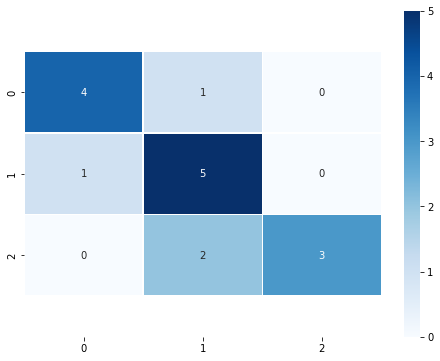

In [ ]:
# Confusion Matrix를 통해서 모델의 성능을 확인하고, 성능이 안좋은 특정 클래스를 찾아낸 후 데이터 불균형 해소 방법을 적용한
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1,1,1,1,1,1,0,0,0,0,0,2,2,2,2,2]
prediction = [1,1,1,0,1,1,0,0,0,1,0,2,2,2,1,1]
c_mat = confusion_matrix(actual, prediction) # 실제 라벨, 예측값
plt.figure(figsize = (8,6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues',linewidths=.5)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.savefig('confusion_matrix.png')
plt.show()

